<a href="https://colab.research.google.com/github/msc-acse/acse-8-miniproject-sigmoid/blob/zmr/KMNIST_Layout_deepAlex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setting Up Working Environment

## Sync to GitHub

In [0]:
from getpass import getpass
import os

#checking
user = getpass('github user')
password = getpass('github password')
os.environ['GITHUB_AUTH'] = user + ':' + password

!git clone https://$GITHUB_AUTH@github.com/msc-acse/acse-8-miniproject-sigmoid.git sigmoid_update

github user··········
github password··········
Cloning into 'sigmoid_update'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 147 (delta 4), reused 3 (delta 1), pack-reused 135
Receiving objects: 100% (147/147), 24.96 MiB | 29.55 MiB/s, done.
Resolving deltas: 100% (50/50), done.


## Sync to Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/gdrive/")

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Install Dependencies and CUDA

In [2]:
%pylab inline
!pip install pycm livelossplot

from livelossplot import PlotLosses
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models
import time
import random
import copy

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Populating the interactive namespace from numpy and matplotlib
Cuda installed! Running on GPU!


## Import Tools to Perform Supervised Learning on KMNIST

In [0]:
%load_ext autoreload
%autoreload 2
from sigmoid_update.KMNISTLearning import *

# Define Model Classes
Each model class should include a `forward` method.

In [0]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    # The implementation of the LeNet5 architecture
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
    self.c5 = nn.Linear(16*5*5, 120)
    self.f6 = nn.Linear(120, 84)
    self.output = nn.Linear(84, 10)
    self.act = nn.ReLU()
    
  def forward(self, x):
    # Applying the ReLU activation function throughout the net
    x = self.act(self.c1(x))
    x = self.act(self.s2(x))
    x = self.act(self.c3(x))
    x = self.act(self.s4(x))
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
    x = self.act(self.c5(x))
    x = self.act(self.f6(x))
    return self.output(x)

In [0]:
class mLeNet5(nn.Module):
  def __init__(self):
     super(mLeNet5, self).__init__()
     self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2)
     self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)
     self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
     self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)
     self.c5 = nn.Linear(16*5*5, 1150)
     self.f6 = nn.Linear(1150, 256)
     self.output = nn.Linear(256, 10)
     self.act = nn.ReLU()
     self.dp = nn.Dropout(0.5)

  def forward(self, x):
     x = self.act(self.c1(x))
     x = self.act(self.s2(x))
     x = self.act(self.c3(x))
     x = self.act(self.s4(x))
     x = x.view(-1, x.size(1)*x.size(2)*x.size(3))
     x = self.act(self.c5(x))
     x = self.dp(x)
     x = self.act(self.f6(x))
     x = self.dp(x)
     return self.output(x)

In [0]:
class AlexNetMod(nn.Module):

    def __init__(self, num_classes=1000,train=True):
        super(AlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        if train:
            self.classifier = nn.Sequential(
                nn.Dropout(),
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, num_classes),
            )
            
        else:
            self.classifier = nn.Sequential(
                nn.Linear(256 * 6 * 6, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Linear(4096, num_classes),
            )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
class mAlexNetMod(nn.Module):

    def __init__(self, num_classes=1000,train=True):
        super(mAlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        

    def forward(self, x):
        x = self.features(x)
        print(x.shape)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [0]:
class DeepAlexNetMod(nn.Module):

    def __init__(self, num_classes=1000,train=True):
        super(DeepAlexNetMod, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 256, kernel_size=4, padding=0, stride=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True), 
            
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            
            nn.MaxPool2d(kernel_size=3, stride=2),

        )
        
        
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        

    def forward(self, x):
        x = self.features(x)
        #print(x.shape)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Import Data as `torch.Tensor`

In [9]:
# Import Data
path="sigmoid/data/"
train_data = np.load(path+"kmnist-train-imgs.npy")
test_data = np.load(path+"kmnist-test-imgs.npy")
train_labels = np.load(path+"kmnist-train-labels.npy")
classmap = pd.read_csv(path+"kmnist_classmap.csv")

# Tensor of training data
X = torch.from_numpy(train_data).float()
# Tensor of training labels
y = torch.from_numpy(train_labels).long()
#  Tensor of test data
X_test = torch.from_numpy(test_data).float()

# Size Check
print("Train Data:", X.size())
print("Test Data:", X_test.size())
print("Train Labels:", y.size())

Train Data: torch.Size([60000, 28, 28])
Test Data: torch.Size([10000, 28, 28])
Train Labels: torch.Size([60000])


# Model Training and Saving

## AlexNet5 with no Augmentation

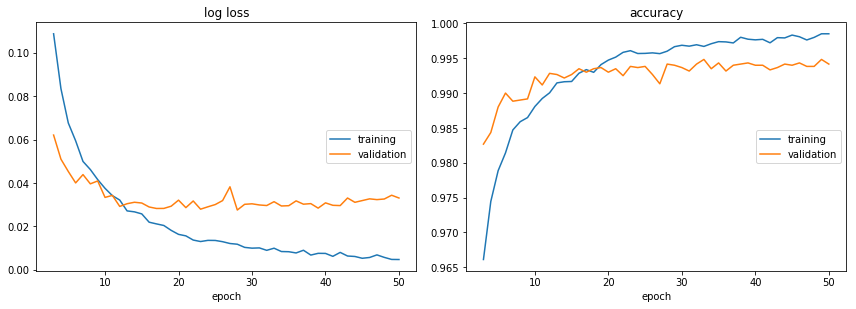

log loss:
training   (min:    0.005, max:    0.475, cur:    0.005)
validation (min:    0.028, max:    0.141, cur:    0.033)

accuracy:
training   (min:    0.851, max:    0.999, cur:    0.999)
validation (min:    0.960, max:    0.995, cur:    0.994)
None


In [53]:
# Lenet5 no augmentation
# Hyperparameters

lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 50

model = DeepAlexNetMod(num_classes=10)
#model = mAlexNetMod(num_classes=10)
optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
loss_function = nn.CrossEntropyLoss()

learning = SupervisedLearning(X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device=device,
                 transform=True, 
                 seed=42, n_epochs=n_epochs,
                 val_ratio=0.1, n_splits=1, 
                 early_stop = False,
                 patience = 5,
                 tol = 0.001)

t = learning.train_wrapper(train_full=False)
print(t)

In [0]:
DeepAlex_model = learning.model

## LeNet5 Dropout with no augmentation, K-Fold validation

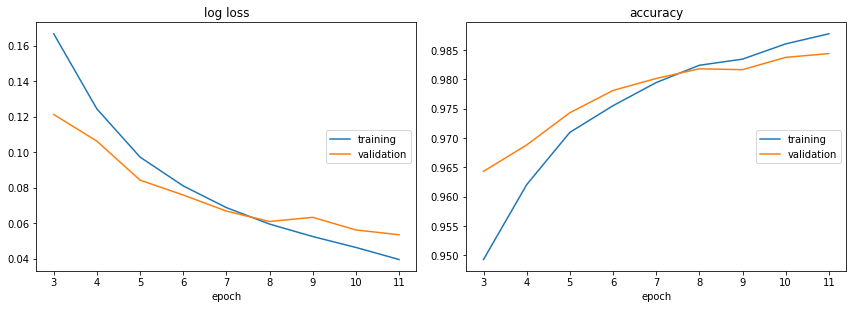

log loss:
training   (min:    0.040, max:    0.875, cur:    0.040)
validation (min:    0.054, max:    0.346, cur:    0.054)

accuracy:
training   (min:    0.721, max:    0.988, cur:    0.988)
validation (min:    0.894, max:    0.984, cur:    0.984)


KeyboardInterrupt: ignored

In [0]:
# Lenet5 Dropout no augmentation, K-Fold
# Hyperparameters

lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

model = AlexNetMod(num_classes=10).to(device)
optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=0 )
loss_function = nn.CrossEntropyLoss()


ttt = KFoldValidation(X, y, model, optimiser, loss_function, batch_size, test_batch_size,
                 device=device, 
                 confusion_matrix=True, 
                 transform=True, 
                 seed=42, n_epochs=30,
                 n_folds=3, 
                 early_stop = False,
                 patience = 5,
                 tol = 0.001
                     )

result = ttt.cross_validation()



## Load model and perform predictions on test set

In [57]:
# Load model and perform predictions on test set
path = F"/content/gdrive/My Drive/Models/"
model_name="DeepAlex_subset_994"
#model_alex_aug_full = torch.load(path + model_name + '.pth')
norm_mean, norm_std = torch.mean(X/255.), torch.std(X/255.)

y_preds_full, sub_full = evaluate(X_test/255, DeepAlex_model, norm_mean, norm_std, 
                                       test_batch_size=30, 
                                       test_transform=None, 
                                       device=device, 
                                       save_to_csv=True, 
                                       path=path+"DeepAlex_subset_994.csv")

print(y_preds_full)

[2 9 3 ... 9 4 2]


In [58]:
model_save(DeepAlex_model, model_name, path, 994)

Saving model under: /content/gdrive/My Drive/Models/DeepAlex_subset_994_4.pth


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type DeepAlexNetMod. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [59]:
test_labels = np.load("./gdrive/My Drive/data/kmnist-test-labels.npz")
test_label_array = test_labels['arr_0']
print("Accuracy: ", 1 - len(np.where((y_preds_full - test_label_array)!= 0)[0])/len(test_label_array))

Accuracy:  0.9773
